In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import RandomOverSampler
%matplotlib inline


df = pd.read_csv("defaults.csv", header = 1, index_col = 'ID')
df.columns = [x.lower() for x in list(df.columns)]
df.columns = ['credit_amount', 'sex', 'education', 'marital_status', 'age', 'pay_sept', 'pay_aug',
       'pay_jul', 'pay_jun', 'pay_may', 'pay_apr', 'bill_amt_sept', 'bill_amt_aug',
       'bill_amt_jul', 'bill_amt_jun', 'bill_amt_may', 'bill_amt_apr', 'pay_amt_sept',
       'pay_amt_aug', 'pay_amt_jul', 'pay_amt_jun', 'pay_amt_may', 'pay_amt_apr',
       'default']

for column in ['credit_amount', 'bill_amt_sept', 'bill_amt_aug',
       'bill_amt_jul', 'bill_amt_jun', 'bill_amt_may', 'bill_amt_apr', 'pay_amt_sept',
       'pay_amt_aug', 'pay_amt_jul', 'pay_amt_jun', 'pay_amt_may', 'pay_amt_apr']:
    df[column] = df[column]/1000
    
gender_remapping = {1: 'male', 2: 'female'}
df.sex = df.sex.map(gender_remapping)

df.education = df.education.astype(str)
education_remapping = {'1': 'grad_school', '2': 'bachelors', '3': 'high_school', '4': 'other', 
                       '5': 'other', '6': 'other', '0': 'other'}
df.education = df.education.map(education_remapping)

df.marital_status = df.marital_status.astype(str)
marital_status_remapping = {'1': 'married', '2': 'single', '3': 'divorced', '0': 'other'}
df.marital_status = df.marital_status.map(marital_status_remapping)

# Original dataset

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
credit_amount     30000 non-null float64
sex               30000 non-null object
education         30000 non-null object
marital_status    30000 non-null object
age               30000 non-null int64
pay_sept          30000 non-null int64
pay_aug           30000 non-null int64
pay_jul           30000 non-null int64
pay_jun           30000 non-null int64
pay_may           30000 non-null int64
pay_apr           30000 non-null int64
bill_amt_sept     30000 non-null float64
bill_amt_aug      30000 non-null float64
bill_amt_jul      30000 non-null float64
bill_amt_jun      30000 non-null float64
bill_amt_may      30000 non-null float64
bill_amt_apr      30000 non-null float64
pay_amt_sept      30000 non-null float64
pay_amt_aug       30000 non-null float64
pay_amt_jul       30000 non-null float64
pay_amt_jun       30000 non-null float64
pay_amt_may       30000 non-null float64
pay_am

In [3]:
df.columns

Index(['credit_amount', 'sex', 'education', 'marital_status', 'age',
       'pay_sept', 'pay_aug', 'pay_jul', 'pay_jun', 'pay_may', 'pay_apr',
       'bill_amt_sept', 'bill_amt_aug', 'bill_amt_jul', 'bill_amt_jun',
       'bill_amt_may', 'bill_amt_apr', 'pay_amt_sept', 'pay_amt_aug',
       'pay_amt_jul', 'pay_amt_jun', 'pay_amt_may', 'pay_amt_apr', 'default'],
      dtype='object')

# Applying random oversampling, as we are dealing with imbalanced dataset.

In [4]:
ros = RandomOverSampler(random_state=0)

In [5]:
X_columns = df.drop(['default'], axis = 1).columns
X = df.drop(['default'], axis = 1).values
y = df[['default']].values.ravel()

X_resampled, y_resampled = ros.fit_resample(X, y)

In [6]:
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0, 23364), (1, 23364)]


# Train - test split.

In [7]:
X_train, X_test, y_train, y_test = \
        train_test_split(X_resampled, y_resampled, stratify = y_resampled, test_size=0.3, random_state=1)

In [8]:
print(sorted(Counter(y_train).items()))

[(0, 16355), (1, 16354)]


In [9]:
print(sorted(Counter(y_test).items()))

[(0, 7009), (1, 7010)]


In [10]:
X_train = pd.DataFrame(X_train, columns = X_columns)
X_test = pd.DataFrame(X_test, columns = X_columns)

In [11]:
X_train['credit_amount'] = X_train['credit_amount'].astype('int64')
X_train.loc[:, 'age':'pay_apr'] = X_train.loc[:, 'age':'pay_apr'].astype('int64')
X_train.loc[:, 'bill_amt_sept':'pay_amt_apr'] = X_train.loc[:, 'bill_amt_sept':'pay_amt_apr'].astype('float64')

X_test['credit_amount'] = X_test['credit_amount'].astype('int64')
X_test.loc[:, 'age':'pay_apr'] = X_test.loc[:, 'age':'pay_apr'].astype('int64')
X_test.loc[:, 'bill_amt_sept':'pay_amt_apr'] = X_test.loc[:, 'bill_amt_sept':'pay_amt_apr'].astype('float64')

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32709 entries, 0 to 32708
Data columns (total 23 columns):
credit_amount     32709 non-null int64
sex               32709 non-null object
education         32709 non-null object
marital_status    32709 non-null object
age               32709 non-null int64
pay_sept          32709 non-null int64
pay_aug           32709 non-null int64
pay_jul           32709 non-null int64
pay_jun           32709 non-null int64
pay_may           32709 non-null int64
pay_apr           32709 non-null int64
bill_amt_sept     32709 non-null float64
bill_amt_aug      32709 non-null float64
bill_amt_jul      32709 non-null float64
bill_amt_jun      32709 non-null float64
bill_amt_may      32709 non-null float64
bill_amt_apr      32709 non-null float64
pay_amt_sept      32709 non-null float64
pay_amt_aug       32709 non-null float64
pay_amt_jul       32709 non-null float64
pay_amt_jun       32709 non-null float64
pay_amt_may       32709 non-null float64
pay_amt_

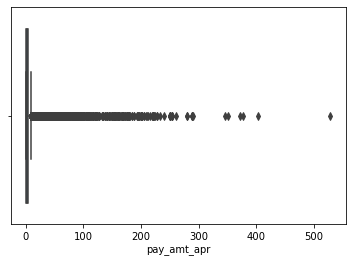

In [13]:
_ = sns.boxplot(X_train['pay_amt_apr'])  
plt.show()

In [14]:
float_columns = X_train.select_dtypes(include=['float64']).columns
int_columns=X_train.select_dtypes(include=['int64']).columns

numeric_columns=float_columns.union(int_columns)

categorical_columns = X_train.select_dtypes(include=['object']).columns

In [15]:
categorical_columns

Index(['sex', 'education', 'marital_status'], dtype='object')

In [16]:
numeric_columns

Index(['age', 'bill_amt_apr', 'bill_amt_aug', 'bill_amt_jul', 'bill_amt_jun',
       'bill_amt_may', 'bill_amt_sept', 'credit_amount', 'pay_amt_apr',
       'pay_amt_aug', 'pay_amt_jul', 'pay_amt_jun', 'pay_amt_may',
       'pay_amt_sept', 'pay_apr', 'pay_aug', 'pay_jul', 'pay_jun', 'pay_may',
       'pay_sept'],
      dtype='object')

# Replacing outliers, imputing missing numerical and categorical values.

In [17]:
def outlier_replace(data,train,column):
    quartile_1, quartile_3 = np.percentile(train[column], [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (float(iqr) * 1.5)
    upper_bound = quartile_3 + (float(iqr) * 1.5)
    data.loc[(data[column]<lower_bound) | (data[column] > upper_bound),[column]] = train[column].median()
    return data[column]

In [18]:
def imputation_missing_numerical(data,train,column):
    data[column] = data[column].fillna(train[column].median())
    return data[column]

In [19]:
def imputation_missing_categorical(data,column):
    data[column] = data[column].fillna('other')
    return data[column]   

In [20]:
for numeric in numeric_columns:
    X_train[numeric] = outlier_replace(X_train,X_train,numeric)
    #X_train[numeric] = imputation_missing_numerical(train_x,train_x,numeric)
    
    X_test[numeric] = outlier_replace(X_test,X_train,numeric)
    #X_test[numeric] = imputation_missing_numerical(X_test,X_train,numeric)   
    
#for categorical in categorical_columns:
#    X_train[categorical] = imputation_missing_categorical(X_train,categorical)
#    X_test[categorical] = imputation_missing_categorical(X_test,categorical)   

In [21]:
def dummies(data,col):
    y = pd.get_dummies(data[col],prefix=col)
    data.drop([col],axis=1,inplace=True)
    return y   

In [22]:
X_train_dummies  = pd.concat([dummies(X_train,col) for col in categorical_columns], axis=1)
X_test_dummies  = pd.concat([dummies(X_test,col) for col in categorical_columns], axis=1) 

In [23]:
# Get missing columns in the training vs test set
missing_cols = set(X_train_dummies.columns) - set(X_test_dummies.columns )
print(missing_cols)

# Add a missing column in the test set with default values equal to 0
for col in missing_cols:
    X_test_dummies[col] = 0

X_test_dummies=X_test_dummies[X_train_dummies.columns]

set()


In [24]:
scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

In [25]:
X_train = pd.concat([X_train[numeric_columns],X_train_dummies],axis=1)
X_test = pd.concat([X_test[numeric_columns],X_test_dummies],axis=1)

In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32709 entries, 0 to 32708
Data columns (total 30 columns):
age                        32709 non-null float64
bill_amt_apr               32709 non-null float64
bill_amt_aug               32709 non-null float64
bill_amt_jul               32709 non-null float64
bill_amt_jun               32709 non-null float64
bill_amt_may               32709 non-null float64
bill_amt_sept              32709 non-null float64
credit_amount              32709 non-null float64
pay_amt_apr                32709 non-null float64
pay_amt_aug                32709 non-null float64
pay_amt_jul                32709 non-null float64
pay_amt_jun                32709 non-null float64
pay_amt_may                32709 non-null float64
pay_amt_sept               32709 non-null float64
pay_apr                    32709 non-null float64
pay_aug                    32709 non-null float64
pay_jul                    32709 non-null float64
pay_jun                    32709 non-null

In [27]:
X_train.shape, X_test.shape

((32709, 30), (14019, 30))

# Learning curve plotting function

In [28]:
def learning_curve_plot(X_train, y_train, clf, clf_name):
    train_sizes, train_scores, test_scores =\
                    learning_curve(estimator=clf, 
                    X=X_train, 
                    y=y_train,
                    train_sizes=np.linspace(0.1, 1.0, 5),
                    cv=5,
                    n_jobs=-1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, 
             color='blue', marker='o', 
             markersize=5, label='training accuracy')

    plt.fill_between(train_sizes, 
                     train_mean + train_std,
                     train_mean - train_std, 
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, 
             color='green', linestyle='--', 
             marker='s', markersize=5, 
             label='validation accuracy')

    plt.fill_between(train_sizes, 
                     test_mean + test_std,
                     test_mean - test_std, 
                     alpha=0.15, color='green')

    plt.grid()
    plt.title('Learning curve for ' + str(clf_name))
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([min(test_mean) - 0.025, max(train_mean) + 0.025])
    plt.tight_layout()
    return plt

# Validation curves plotting function

In [29]:
def validation_curve_plot(X_train, y_train, clf, param_range, param_name, clf_name):

    train_scores, test_scores = validation_curve(
                    estimator=clf, 
                    X=X_train, 
                    y=y_train, 
                    param_name=param_name, 
                    param_range=param_range,
                    cv=5,
                    n_jobs = -1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(param_range, train_mean, 
             color='blue', marker='o', 
             markersize=5, label='training accuracy')

    plt.fill_between(param_range, train_mean + train_std,
                     train_mean - train_std, alpha=0.15,
                     color='blue')

    plt.plot(param_range, test_mean, 
             color='green', linestyle='--', 
             marker='s', markersize=5, 
             label='validation accuracy')

    plt.fill_between(param_range, 
                     test_mean + test_std,
                     test_mean - test_std, 
                     alpha=0.15, color='green')

    plt.grid()
    plt.xscale('log')
    plt.legend(loc='lower right')
    plt.xlabel('Parameter ' + str(param_name))
    plt.ylabel('Accuracy')
    plt.title('Validation curve for ' + str(clf_name) + ':' + str(param_name))
    plt.ylim([min(test_mean) - 0.025, max(train_mean) + 0.025])
    plt.tight_layout()
    return plt

# Logistic regression

In [30]:
from sklearn.metrics import roc_auc_score

clf = LogisticRegression(solver = 'lbfgs', penalty = 'l2', n_jobs = -1, max_iter = 150)

# Fit the model on the trainng data.
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print('Training accuracy:', accuracy_score(y_true = y_train, y_pred = y_pred_train))
print('Test accuracy:', accuracy_score(y_true = y_test, y_pred = y_pred_test))
print('AUC score for the test data:', roc_auc_score(y_true = y_test, y_score = clf.predict_proba(X_test)[:,1]))

Training accuracy: 0.675379864869
Test accuracy: 0.675797132463
AUC score for the test data: 0.726086330007


# Stratified K-fold cross-validation (logistic regression).

In [31]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

scores = []
for k, (train_fold, test_fold) in enumerate(kfold.split(X_train.values, y_train)):
    clf.fit(X_train.values[train_fold], y_train[train_fold])
    score = clf.score(X_train.values[test_fold], y_train[test_fold])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Train accuracy: %.3f' % (k+1, np.bincount(y_train[train_fold]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Class dist.: [13084 13083], Train accuracy: 0.674
Fold: 2, Class dist.: [13084 13083], Train accuracy: 0.666
Fold: 3, Class dist.: [13084 13083], Train accuracy: 0.674
Fold: 4, Class dist.: [13084 13083], Train accuracy: 0.677
Fold: 5, Class dist.: [13084 13084], Train accuracy: 0.682

CV accuracy: 0.674 +/- 0.005


# Validation curve (logistic regression)

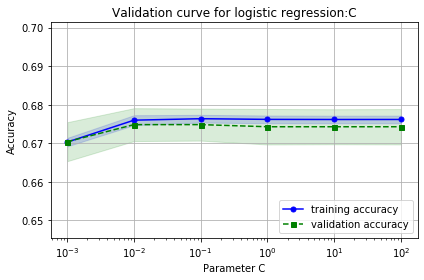

In [32]:
clf_param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

validation_curve_plot(X_train.values, y_train, clf, clf_param_range, 'C', 'logistic regression').show()

# Hyperparameter tuning using grid search (logistic regression)

In [33]:
C_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

param_grid = [{'C': C_range, 'solver': solvers}]

gs = GridSearchCV(estimator=clf, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=5,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.674829557614
{'C': 0.01, 'solver': 'lbfgs'}


In [34]:
best_clf = gs.best_estimator_
best_clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % best_clf.score(X_test, y_test))

Test accuracy: 0.675


# Learning curve (logistic regression)

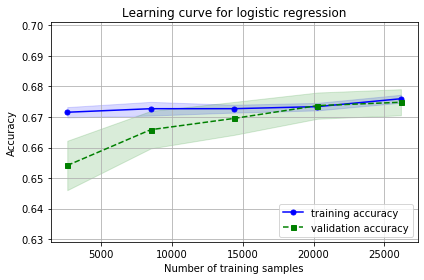

In [35]:
learning_curve_plot(X_train.values, y_train, best_clf, 'logistic regression').show()

# Confusion matrix (logistic regression)

In [36]:
y_pred = best_clf.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[5051 1958]
 [2601 4409]]


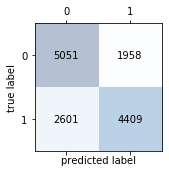

In [37]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')

plt.tight_layout()
# plt.savefig('./figures/confusion_matrix.png', dpi=300)
plt.show()

**We want to have 1 as a positive class in the confusion matric in the top left corner, therefore we need to swap labels in the confusion matrix.**

**1 - default**
**0 - no default**

In [38]:
y_pred = best_clf.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = [1,0])
print(confmat)

[[4409 2601]
 [1958 5051]]


In [39]:
print('Precisoin from the above matrix = ' + str(confmat[0][0]/(confmat[0][0] + confmat[1][0])))

Precisoin from the above matrix = 0.692476833674


**Metrics using sklearn precision_score() function**

In [40]:
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.692
Recall: 0.629
F1: 0.659


In [52]:
print('Test accuracy:', accuracy_score(y_true = y_test, y_pred = y_pred))

Test accuracy: 0.674798487767


# Random Forest classifier

In [42]:
rand_forest = RandomForestClassifier(n_jobs = -1)

# Fit the model on the trainng data.
rand_forest.fit(X_train, y_train)

print('Training accuracy (default random forest):', 
      accuracy_score(rand_forest.predict(X_train), y_train))
print('Test accuracy (default random forest):', 
      accuracy_score(rand_forest.predict(X_test), y_test))

//anaconda/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training accuracy (default random forest): 0.995597541961
Test accuracy (default random forest): 0.875597403524


# Validation curve (random forest)

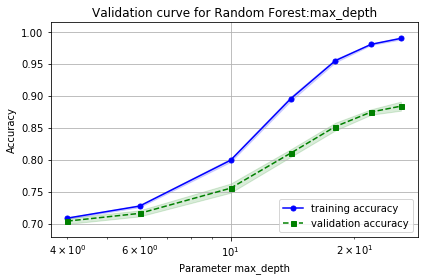

In [44]:
max_depth = [4, 6, 10, 14, 18, 22, 26]

validation_curve_plot(X_train.values, y_train, rand_forest, max_depth, 
                      'max_depth', 'Random Forest').show()

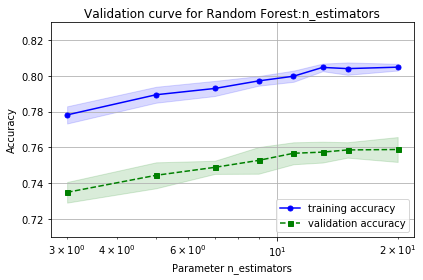

In [46]:
n_estimators = [3, 5, 7, 9, 11, 13, 15, 20]

rand_forest_upd = RandomForestClassifier(n_jobs = -1, max_depth = 10)

validation_curve_plot(X_train.values, y_train, rand_forest_upd, n_estimators, 
                      'n_estimators', 'Random Forest').show()

# Stratified K-fold cross-validation (random forest).

In [47]:
rand_forest_best = RandomForestClassifier(n_jobs = -1, max_depth = 10, n_estimators = 15)

scores_rf = []
for k, (train_fold, test_fold) in enumerate(kfold.split(X_train.values, y_train)):
    rand_forest_best.fit(X_train.values[train_fold], y_train[train_fold])
    score = rand_forest_best.score(X_train.values[test_fold], y_train[test_fold])
    scores_rf.append(score)
    print('Fold: %s, Class dist.: %s, Train accuracy: %.3f' % (k+1, np.bincount(y_train[train_fold]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores_rf), np.std(scores_rf)))

Fold: 1, Class dist.: [13084 13083], Train accuracy: 0.752
Fold: 2, Class dist.: [13084 13083], Train accuracy: 0.755
Fold: 3, Class dist.: [13084 13083], Train accuracy: 0.759
Fold: 4, Class dist.: [13084 13083], Train accuracy: 0.761
Fold: 5, Class dist.: [13084 13084], Train accuracy: 0.758

CV accuracy: 0.757 +/- 0.003


# Confusion matrix (optimized random forest)

In [48]:
rand_forest_best.fit(X_train, y_train)
y_pred_rf = rand_forest_best.predict(X_test)
confmat_rf = confusion_matrix(y_true=y_test, y_pred=y_pred_rf, labels = [1,0])
print(confmat_rf)

[[4857 2153]
 [1292 5717]]


In [50]:
print('Precision (optimized random forest): %.3f' % precision_score(y_true=y_test, y_pred=y_pred_rf))
print('Recall (optimized random forest): %.3f' % recall_score(y_true=y_test, y_pred=y_pred_rf))
print('F1 (optimized random forest): %.3f' % f1_score(y_true=y_test, y_pred=y_pred_rf))

Precision (optimized random forest): 0.790
Recall (optimized random forest): 0.693
F1 (optimized random forest): 0.738


In [51]:
print('Training accuracy (optimized random forest):', 
      accuracy_score(rand_forest_best.predict(X_train), y_train))
print('Test accuracy (optimized random forest):', 
      accuracy_score(rand_forest_best.predict(X_test), y_test))

Training accuracy (optimized random forest): 0.796936622948
Test accuracy (optimized random forest): 0.754262072901


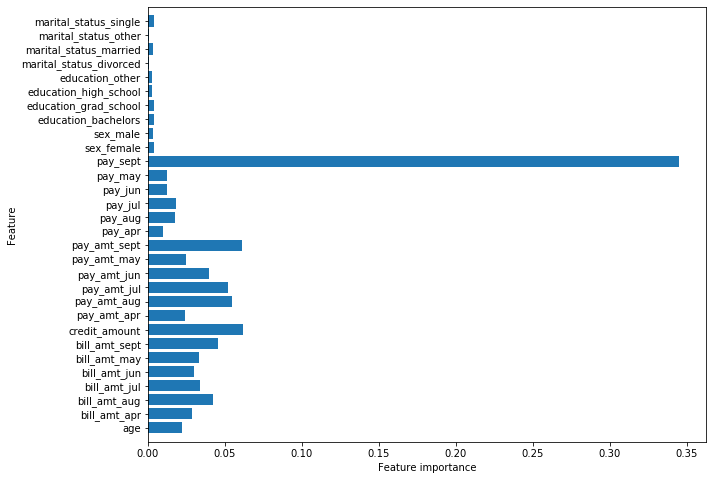

In [55]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    _ = plt.figure(figsize=(10,8))
    _ = plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    _ = plt.yticks(np.arange(n_features), X_train.columns)
    _ = plt.xlabel("Feature importance")
    _ = plt.ylabel("Feature")
    _ = plt.ylim(-1, n_features)
    return plt

plot_feature_importances(rand_forest_best).show()

# SVM

In [57]:
from sklearn.svm import SVC

svm = SVC()

# Fit the model on the trainng data.
svm.fit(X_train, y_train)

y_pred_svm_train = svm.predict(X_train)
y_pred_svm_test = svm.predict(X_test)

print('Training accuracy (default SVM):', accuracy_score(y_true = y_train, y_pred = y_pred_svm_train))
print('Test accuracy (default SVM):', accuracy_score(y_true = y_test, y_pred = y_pred_svm_test))

//anaconda/envs/python3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Training accuracy (default SVM): 0.731052615488
Test accuracy (default SVM): 0.711605678008


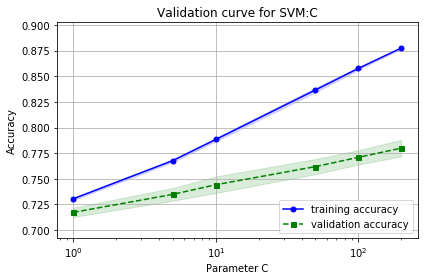

In [58]:
C_range = [1, 5, 10, 50, 100, 200]

validation_curve_plot(X_train.values, y_train, SVC(gamma = 'auto'), C_range, 'C', 'SVM').show()

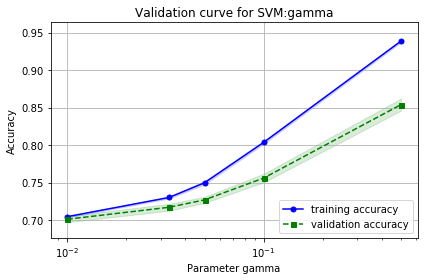

In [59]:
gamma_range = [0.01, 0.033, 0.05, 0.1, 0.5]

validation_curve_plot(X_train.values, y_train, svm, gamma_range, 'gamma', 'SVM').show()

# Stratified K-fold cross-validation (SVM).

In [40]:
from sklearn.svm import SVC
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

svm_best = SVC(C=5, gamma=0.05)

scores_svm = []
for k, (train_fold, test_fold) in enumerate(kfold.split(X_train.values, y_train)):
    svm_best.fit(X_train.values[train_fold], y_train[train_fold])
    score = svm_best.score(X_train.values[test_fold], y_train[test_fold])
    scores_svm.append(score)
    print('Fold: %s, Class dist.: %s, Train accuracy: %.3f' % (k+1, np.bincount(y_train[train_fold]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores_svm), np.std(scores_svm)))

Fold: 1, Class dist.: [13084 13083], Train accuracy: 0.746
Fold: 2, Class dist.: [13084 13083], Train accuracy: 0.749
Fold: 3, Class dist.: [13084 13083], Train accuracy: 0.748
Fold: 4, Class dist.: [13084 13083], Train accuracy: 0.755
Fold: 5, Class dist.: [13084 13084], Train accuracy: 0.758

CV accuracy: 0.751 +/- 0.005


# Confusion matrix (optimized SVM)

In [41]:
svm_best.fit(X_train, y_train)
y_pred_best_svm_train = svm_best.predict(X_train)
y_pred_best_svm_test = svm_best.predict(X_test)
confmat_svm = confusion_matrix(y_true=y_test, y_pred=y_pred_best_svm_test, labels = [1,0])
print(confmat_svm)

[[4856 2154]
 [1585 5424]]


In [42]:
print('Precision (optimized SVM): %.3f' % precision_score(y_true=y_test, y_pred=y_pred_best_svm_test))
print('Recall (optimized SVM): %.3f' % recall_score(y_true=y_test, y_pred=y_pred_best_svm_test))
print('F1 (optimized SVM): %.3f' % f1_score(y_true=y_test, y_pred=y_pred_best_svm_test))

Precision (optimized SVM): 0.754
Recall (optimized SVM): 0.693
F1 (optimized SVM): 0.722


In [43]:
print('Training accuracy (optimized SVM):', 
      accuracy_score(y_true = y_train, y_pred = y_pred_best_svm_train))
print('Test accuracy (optimized SVM):', 
      accuracy_score(y_true = y_test, y_pred = y_pred_best_svm_test))

Training accuracy (optimized SVM): 0.802317404996
Test accuracy (optimized SVM): 0.733290534275
